# Deep Learning & Art: Neural Style Transfer

In this assignment, you will learn about Neural Style Transfer. This algorithm was created by [Gatys et al. (2015).](https://arxiv.org/abs/1508.06576)

- Implement the neural style transfer algorithm 
- Generate novel artistic images using your algorithm 

Acknowledgement: This is insipred by https://www.coursera.org/specializations/deep-learning#courses

In [0]:
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!pwd
os.chdir('gdrive/My Drive/Colab Notebooks/Optimization Methods in Machine Learning')
!pwd
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content
/content/gdrive/My Drive/Colab Notebooks/Optimization Methods in Machine Learning
 71KhW7VgXNL._SX466_.jpg
'A Neural Algorithm of Artistic Style.pdf'
 Art_Generation_with_Neural_Style_Transfer.ipynb
'AUTOGRAD: AUTOMATIC DIFFERENTIATION.ipynb'
 Homework3.ipynb
'Homework#7_Siner_Ved_Sangyun(siy518,vhp219,sak518).ipynb'
'HW2: Implement Gradient Descent Algorithm.ipynb'
 IMG_4622.JPG
 IMG_4622.JPG.1
 IMG_4622.JPG.2
'Implement a Gradient Descent Algorithm

In [0]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import torch
from torchvision import transforms
import numpy as np
import pprint
import torch.optim as optim

%matplotlib inline

## 1 - Introduction

Neural Style Transfer (NST) is one of the most fun techniques in deep learning. It merges two images, namely: a **"content" image (C) and a "style" image (S), to create a "generated" image (G**). 

## 2 - Transfer Learning

In [0]:
torch.cuda.is_available()

True

In [0]:
import torchvision.models as models
model = models.vgg19(pretrained=True)
model = model.cuda()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [0]:
"There are %dM parameters in our models" % (np.sum([w.numel() for w in model.parameters()])/10**6)

'There are 143M parameters in our models'

### Replace all max-pooling layers with average pooling
Paper "A Neural Algorithm of Artistic Style" said "For image synthesis we found that replacing the max-pooling operation by average pooling improves the gradient flow and one obtains slightly more appealing results, which is why the images shown were generated with average pooling."


In [0]:
for i, layer in enumerate(model.features):
  if isinstance(layer, torch.nn.MaxPool2d):
    model.features[i] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

In [0]:
# Don't need to train vgg model
for param in model.parameters():
    param.requires_grad_(False)

## Getting Content and Style Images

(600, 800, 3)


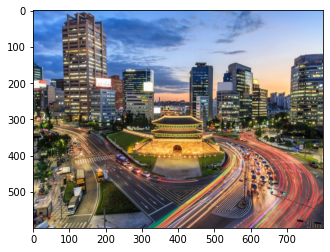

In [0]:
import cv2
img = cv2.imread('./korea.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (800,600))
plt.imshow(img)
print (img.shape)
contentImage = torch.tensor(img/255.0).float().cuda()

### Normalization part

In [0]:
mean_vals= contentImage.view(contentImage.shape[0], -1).mean(dim=1)
std_vals = contentImage.view(contentImage.shape[0], -1).std(dim=1)
normalizer = transforms.Normalize(mean=mean_vals, std=std_vals) 
#normalizer = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [0]:
content_tensor = normalizer(contentImage) 

In [0]:
style_tensor = normalizer(contentImage) 

## Obtaining various layers from the model
There are the 16 convolutional layers and 5 pooling layers in the 19 layer VGGNetwork. But, don't need to use the fully connected layers.

In [0]:
# We care about the first part of the model (model.features)
layers = []
for idx, m in enumerate(model.features.modules()):
    if idx > 0:
      m.requires_grad = False
      print(idx, '->', m)
      layers.append([m,isinstance(m, torch.nn.Conv2d)])  # we will store all the layers into list for later usage

1 -> Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2 -> ReLU(inplace=True)
3 -> Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
4 -> ReLU(inplace=True)
5 -> AvgPool2d(kernel_size=2, stride=2, padding=0)
6 -> Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
7 -> ReLU(inplace=True)
8 -> Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
9 -> ReLU(inplace=True)
10 -> AvgPool2d(kernel_size=2, stride=2, padding=0)
11 -> Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
12 -> ReLU(inplace=True)
13 -> Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
14 -> ReLU(inplace=True)
15 -> Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
16 -> ReLU(inplace=True)
17 -> Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
18 -> ReLU(inplace=True)
19 -> AvgPool2d(kernel_size=2, stride=2, padding=0)
20 -> Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

In [0]:
layers_ReLU  = []
for idx, m in enumerate(model.features.modules()):
    if idx > 0:
      m.requires_grad = False
      print(idx, '->', m)
      layers_ReLU.append([m,isinstance(m, torch.nn.ReLU)])

1 -> Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2 -> ReLU(inplace=True)
3 -> Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
4 -> ReLU(inplace=True)
5 -> AvgPool2d(kernel_size=2, stride=2, padding=0)
6 -> Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
7 -> ReLU(inplace=True)
8 -> Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
9 -> ReLU(inplace=True)
10 -> AvgPool2d(kernel_size=2, stride=2, padding=0)
11 -> Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
12 -> ReLU(inplace=True)
13 -> Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
14 -> ReLU(inplace=True)
15 -> Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
16 -> ReLU(inplace=True)
17 -> Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
18 -> ReLU(inplace=True)
19 -> AvgPool2d(kernel_size=2, stride=2, padding=0)
20 -> Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

In [0]:
imgInput = torch.transpose(contentImage.unsqueeze(0),1,3)
aCs=[]
for l,isConv in layers_ReLU:
  imgInput = l(imgInput)
  if isConv:
    aCs.append(imgInput)
    print ("shape of this is",imgInput.shape)

shape of this is torch.Size([1, 64, 800, 600])
shape of this is torch.Size([1, 64, 800, 600])
shape of this is torch.Size([1, 128, 400, 300])
shape of this is torch.Size([1, 128, 400, 300])
shape of this is torch.Size([1, 256, 200, 150])
shape of this is torch.Size([1, 256, 200, 150])
shape of this is torch.Size([1, 256, 200, 150])
shape of this is torch.Size([1, 256, 200, 150])
shape of this is torch.Size([1, 512, 100, 75])
shape of this is torch.Size([1, 512, 100, 75])
shape of this is torch.Size([1, 512, 100, 75])
shape of this is torch.Size([1, 512, 100, 75])
shape of this is torch.Size([1, 512, 50, 37])
shape of this is torch.Size([1, 512, 50, 37])
shape of this is torch.Size([1, 512, 50, 37])
shape of this is torch.Size([1, 512, 50, 37])



#### Activate a layer
After this, if you want to access the activations of a particular conv layer for given image, they are stored in this list $aCs$. Feel free to extend this as you need 

## 3 - Neural Style Transfer (NST)

We will build the Neural Style Transfer (NST) algorithm in three steps:

- Build the content cost function $J_{content}(C,G)$
- Build the style cost function $J_{style}(S,G)$
- Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 

### 3.1 - Computing the content cost

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


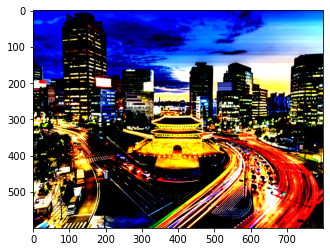

In [0]:
# plt.imshow(contentImage.cpu().data)
plt.imshow(content_tensor.cpu().data)

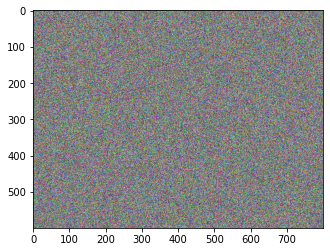

In [0]:
# we choose the G randomly at begining
G2 = torch.rand(contentImage.shape, requires_grad=True, device="cuda")
plt.imshow(G2.cpu().data)

imgInput = torch.transpose(G1.unsqueeze(0),1,3)
aG1s=[]
for l,isConv in layers_ReLU:
  imgInput = l(imgInput)
  if isConv:
    aG1s.append(imgInput)

In [0]:
# GRADED FUNCTION: compute_content_cost
# i = 5
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_C, n_H, n_W), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_C, n_H, n_W), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    J_content = 0
    # return J_content
    n = 4*a_C.view(-1).shape[0]
    J_content += (torch.norm(a_C.view(a_C.shape[1],-1)-a_G.view(a_G.shape[1],-1)**2))/n
    return J_content
# print("J_content = %f" % compute_content_cost(aCs[i], aG2s[i]))    # (e.g. if we pick activation after 5th conv. layer) 

In [0]:
# create adam optimizer which will minimize compute_content_cost by changing "G"
# note after each iteration, you have to compute activations after conv2d for G

import torch.optim as optim
optimizer = optim.Adam([G2],lr=0.1)
i = 4
losslist2 = []
epochs = 500

for epoch in range(epochs):
  optimizer.zero_grad()
  imgInput = torch.transpose(G2.unsqueeze(0),1,3)
  aG2s=[]
  for l,isConv in layers:
    imgInput = l(imgInput)
    if isConv:
      aG2s.append(imgInput)
  loss = compute_content_cost(aCs[i], aG2s[i])
  loss.backward(retain_graph=True)
  optimizer.step()
  losslist2.append(loss.item())

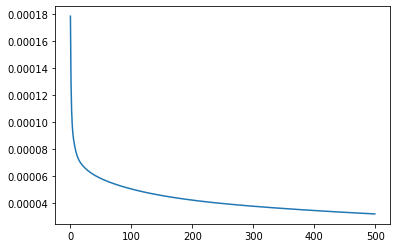

In [0]:
losslist2
plt.plot(losslist2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


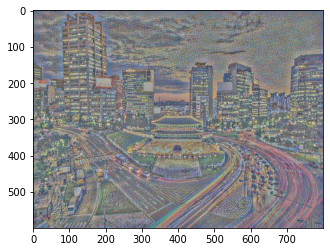

In [0]:
# Image generated after 5th convolution layer 
plt.imshow(G2.cpu().data)

### 3.2 - Computing the style cost

In [0]:
! wget https://images-na.ssl-images-amazon.com/images/I/71KhW7VgXNL._SX466_.jpg

--2020-03-23 01:56:26--  https://images-na.ssl-images-amazon.com/images/I/71KhW7VgXNL._SX466_.jpg
Resolving images-na.ssl-images-amazon.com (images-na.ssl-images-amazon.com)... 151.101.1.16, 151.101.65.16, 151.101.129.16, ...
Connecting to images-na.ssl-images-amazon.com (images-na.ssl-images-amazon.com)|151.101.1.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55708 (54K) [image/jpeg]
Saving to: ‘71KhW7VgXNL._SX466_.jpg.1’

71KhW7VgXNL._SX466_ 100%[===================>]  54.40K  --.-KB/s    in 0.02s   

2020-03-23 01:56:26 (2.71 MB/s) - ‘71KhW7VgXNL._SX466_.jpg.1’ saved [55708/55708]



(600, 800, 3)


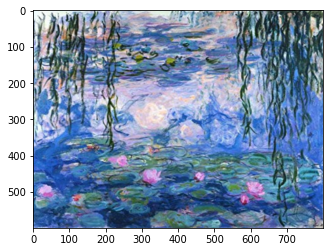

In [0]:
import cv2
img = cv2.imread('./71KhW7VgXNL._SX466_.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (800,600))
plt.imshow(img)
print (img.shape)
styleImage = torch.tensor(img/255.0).float().cuda()

In [0]:
styleinput = torch.transpose(styleImage.unsqueeze(0),1,3)
aSs = [] # activations for style image
# Task: store the activations after conv2d into aSs
for l, isConv in layers:
  styleinput = l(styleinput)
  if isConv:
    aSs.append(styleinput)

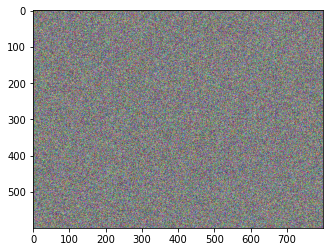

In [0]:
G1 = torch.rand(styleImage.shape, requires_grad=True, device="cuda")
plt.imshow(G1.cpu().data)

In [0]:
imgInput = torch.transpose(G1.unsqueeze(0),1,3)
aG1s=[]
for l,isConv in layers:
  imgInput = l(imgInput)
  if isConv:
    aG1s.append(imgInput)

### 3.2.1 - Style matrix

#### Gram matrix
* The style matrix is also called a "Gram matrix." 

In [0]:
i = 5
layer_matrix = aSs[i].view(aSs[i].shape[1],-1)
gram_matrix1 = torch.mm(layer_matrix, torch.transpose(layer_matrix,0,1))
print(gram_matrix1.shape)
print(gram_matrix1)

torch.Size([256, 256])
tensor([[ 9248.8105,   473.3633,   868.0663,  ...,  2480.0540,  2127.9775,
          1874.7236],
        [  473.3633,  2416.5620,   138.5949,  ...,  1785.5465,  1938.4250,
           928.7401],
        [  868.0663,   138.5949,  5282.8174,  ...,  1704.5554,  1017.3175,
          1648.9125],
        ...,
        [ 2480.0540,  1785.5465,  1704.5554,  ..., 18434.0195,  5187.0840,
          6139.1553],
        [ 2127.9775,  1938.4250,  1017.3175,  ...,  5187.0840, 27038.6426,
          2721.3271],
        [ 1874.7236,   928.7401,  1648.9125,  ...,  6139.1553,  2721.3271,
         16424.1074]], device='cuda:0')


In [0]:
# gram_matrix
# i = 5 #number of layer
# Take A as the convolution layer input 
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    # Gram matrix for convolution layers 
    layer_matrix = A.view(A.shape[1],-1)
    grammatrix = torch.mm(layer_matrix, torch.transpose(layer_matrix, 0, 1))    
    return grammatrix

In [0]:
stylegram1 = gram_matrix(aSs[5])
generatedgram1 = gram_matrix(aG1s[5])
print(stylegram1)

tensor([[ 9248.8105,   473.3633,   868.0663,  ...,  2480.0540,  2127.9775,
          1874.7236],
        [  473.3633,  2416.5620,   138.5949,  ...,  1785.5465,  1938.4250,
           928.7401],
        [  868.0663,   138.5949,  5282.8174,  ...,  1704.5554,  1017.3175,
          1648.9125],
        ...,
        [ 2480.0540,  1785.5465,  1704.5554,  ..., 18434.0195,  5187.0840,
          6139.1553],
        [ 2127.9775,  1938.4250,  1017.3175,  ...,  5187.0840, 27038.6426,
          2721.3271],
        [ 1874.7236,   928.7401,  1648.9125,  ...,  6139.1553,  2721.3271,
         16424.1074]], device='cuda:0')


### 3.2.2 - Style cost

In [0]:
# compute_layer_style_cost

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_C, n_H, n_W), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_C, n_H, n_W), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    stylegram = gram_matrix(a_S)
    generatedgram = gram_matrix(a_G)
    n = (a_S.view(-1).shape[0])**2 
    J_style_layer = (torch.norm(stylegram - generatedgram)**2)/4*n
    
    return J_style_layer

### 3.2.3 Style Weights

In [0]:
STYLE_LAYERS_WEIGHTS = [1.0/16 for i in range(16)] # weights 

In [0]:
for i in range(12):
  STYLE_LAYERS_WEIGHTS[i] = 1/(16*15)
  STYLE_LAYERS_WEIGHTS[12] = 15/16
  if i==11:
    STYLE_LAYERS_WEIGHTS[i+2] = 1/(16*15)
    STYLE_LAYERS_WEIGHTS[i+3] = 1/(16*15)
    STYLE_LAYERS_WEIGHTS[i+4] = 1/(16*15)
print(STYLE_LAYERS_WEIGHTS[12])
print(sum(STYLE_LAYERS_WEIGHTS))

0.9375
1.0


In [0]:
STYLE_LAYERS_WEIGHTS_1 = [0 for i in range(16)]

for i in range(5):
  STYLE_LAYERS_WEIGHTS_1[i] = 1/5
print(STYLE_LAYERS_WEIGHTS_1)
print(sum(STYLE_LAYERS_WEIGHTS_1))

[0.2, 0.2, 0.2, 0.2, 0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1.0


In [0]:
loss = 0
for i in range (5):
  loss += STYLE_LAYERS_WEIGHTS[i]*compute_layer_style_cost(aSs[i],aG1s[i])
print(loss)

tensor(1.4350e+26, device='cuda:0', grad_fn=<AddBackward0>)


You can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 


In [0]:
def compute_style_cost(a_S, a_G, STYLE_LAYERS_WEIGHTS, layer):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    aGs, aSc -- activations after conv2d for G ans S images
    STYLE_LAYERS -- A python list containing a coefficient for each cost layer
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above
    """
    
    # initialize the overall style cost
    J_style = 0
    

    for i in range(layer):
      stylegram = gram_matrix(a_S[i])
      generatedgram = gram_matrix(a_G[i])
      n = ((a_S[i].view(-1).shape[0])**2)*4    
      J_style += STYLE_LAYERS_WEIGHTS[i]*(torch.norm(stylegram - generatedgram)**2)/n    

    return J_style

In [0]:
print("J_style = %f " % compute_style_cost(aSs, aG1s, STYLE_LAYERS_WEIGHTS, 5))

J_style = 0.000601 


### 3.3 - Defining the total cost to optimize

The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

## 4 - Solving the optimization problem

## Alternating between Adam and LBFGS

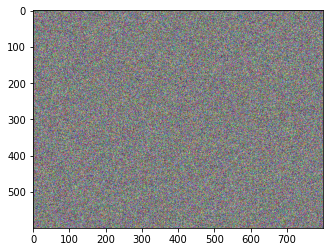

In [0]:
torch.manual_seed(0)
G = torch.rand(contentImage.shape, requires_grad=True, device="cuda")
plt.imshow(G.cpu().data)
plt.show()

In [0]:
# Optimizing using Adam

optimizer = optim.Adam([G],lr=1e-2)

alpha = 1e3 # Paper: 1e3
beta = 1e2 # Paper: 1e4
total_loss_list_ADAM = []
epochs = 1000
i = 4
learningrate = []

for epoch in range(epochs):
  # set grads to 0
  optimizer.zero_grad()
  # compute aGs
  imgInput_final = torch.transpose(G.unsqueeze(0),1,3)
  aGs=[]
  for l,isConv in layers_ReLU:
    imgInput_final = l(imgInput_final)
    if isConv:
      aGs.append(imgInput_final)
  # compute loss function J 
  content_loss = compute_content_cost(aCs[i], aGs[i])
  style_loss = compute_style_cost(aSs, aGs, STYLE_LAYERS_WEIGHTS_1, 5)
  total_loss = alpha*content_loss + beta*style_loss
  # take optimization step
  total_loss.backward(retain_graph=True)
  # adjust_learning_rate(epoch)
  for param_group in optimizer.param_groups:
    learningrate.append(param_group['lr'])
  optimizer.step()
  #scheduler.step()
  total_loss_list_ADAM.append(total_loss.item())
  if epoch % 100 == 0:
    print('Loss at %d iteration is %f' % (epoch, total_loss.item()))

Loss at 0 iteration is 3.060990
Loss at 100 iteration is 0.132011
Loss at 200 iteration is 0.105493
Loss at 300 iteration is 0.093924
Loss at 400 iteration is 0.086943
Loss at 500 iteration is 0.082743
Loss at 600 iteration is 0.080020
Loss at 700 iteration is 0.078113
Loss at 800 iteration is 0.076708
Loss at 900 iteration is 0.075610


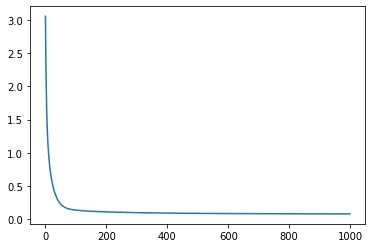

In [0]:
plt.plot(total_loss_list_ADAM)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 799.5, 599.5, -0.5)

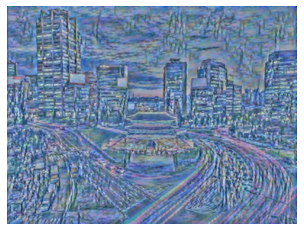

In [0]:
fig = plt.figure()
plt.imshow(G.cpu().data)
plt.axis('off')

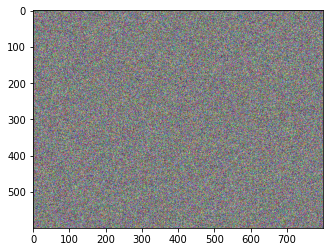

In [0]:
torch.manual_seed(0)
G_LBFGS = torch.rand(contentImage.shape, requires_grad=True, device="cuda")
plt.imshow(G_LBFGS.cpu().data)
plt.show()

In [0]:
# Optimizing using LBFGS
optimizer = optim.LBFGS([G_LBFGS],lr=1e-2, line_search_fn="strong_wolfe", max_iter=500) # max_iter: maximal number of iterations per optimization step

alpha = 1e3 # Paper: 1e3
beta = 1e2 # Paper: 1e4
total_loss_list_LBFGS = []
n_epochs = 1000
i = 4
learningrate = []
epoch = 1000
for epoch in range(epochs):
  # set grads to 0
  def closure():
    optimizer.zero_grad()
    # G_LBFGS.data.clamp_(0, 1)
    # compute aGs
    imgInput_final = torch.transpose(G_LBFGS.unsqueeze(0),1,3)
    aGs=[]
    for l,isConv in layers_ReLU:
      imgInput_final = l(imgInput_final)
      if isConv:
        aGs.append(imgInput_final)
    # compute loss function J 
    content_loss = compute_content_cost(aCs[i], aGs[i])
    style_loss = compute_style_cost(aSs, aGs, STYLE_LAYERS_WEIGHTS_1, 5)
    total_loss = alpha*content_loss + beta*style_loss
    # take optimization step
    total_loss.backward(retain_graph=True)
    # adjust_learning_rate(epoch)
    for param_group in optimizer.param_groups:
      learningrate.append(param_group['lr'])
    return total_loss
  optimizer.step(closure)
  loss = closure()
  total_loss_list_LBFGS.append(loss.item())
  if epoch%100 == 0:
      print ('Loss at %d iteration is %f' % (epoch,loss.item()))
# G_LBFGS.data.clamp_(0, 1)

Loss at 0 iteration is 0.076882
Loss at 100 iteration is 0.070902
Loss at 200 iteration is 0.070902
Loss at 300 iteration is 0.070902
Loss at 400 iteration is 0.070902
Loss at 500 iteration is 0.070902
Loss at 600 iteration is 0.070902
Loss at 700 iteration is 0.070902
Loss at 800 iteration is 0.070902
Loss at 900 iteration is 0.070902


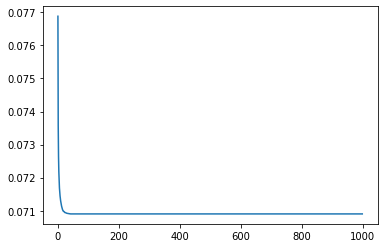

In [0]:
plt.plot(total_loss_list_LBFGS)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 799.5, 599.5, -0.5)

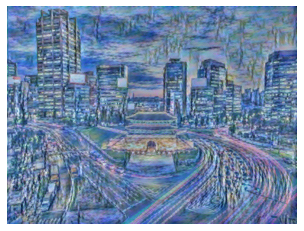

In [0]:
fig = plt.figure()
plt.imshow(G_LBFGS.cpu().data)
plt.axis('off')

[3.060990333557129, 2.567495107650757, 2.1894423961639404, 1.9000757932662964, 1.6770819425582886, 1.5026828050613403, 1.3636544942855835, 1.2503904104232788, 1.1560885906219482, 1.0759587287902832, 1.006654977798462, 0.945797324180603, 0.8916851878166199, 0.843044638633728, 0.7989621758460999, 0.7587255835533142, 0.7217859625816345, 0.6877100467681885, 0.6561557054519653, 0.6268417835235596, 0.5995277762413025, 0.5740240812301636, 0.5501549243927002, 0.5277774333953857, 0.5067614316940308, 0.48699820041656494, 0.46839791536331177, 0.45086535811424255, 0.4343138635158539, 0.4186636209487915, 0.40385085344314575, 0.3898075222969055, 0.37647685408592224, 0.3638194799423218, 0.35178592801094055, 0.34032705426216125, 0.32941552996635437, 0.3190140426158905, 0.3091028332710266, 0.2996656894683838, 0.29067617654800415, 0.2821246087551117, 0.27399250864982605, 0.26627013087272644, 0.2589421570301056, 0.2519983947277069, 0.24542570114135742, 0.2392120510339737, 0.23333948850631714, 0.227791458

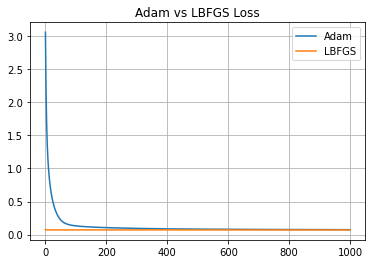

In [0]:
print(total_loss_list_ADAM)
print(total_loss_list_LBFGS)
plt.plot(total_loss_list_ADAM)
plt.plot(total_loss_list_LBFGS)
plt.grid(True)
plt.title("Adam vs LBFGS Loss")
plt.legend((["Adam","LBFGS"]))
plt.show()

LBFGS uses more CPU time and memory but the training error goes down much faster than with Adam or SGD.

### References:

The Neural Style Transfer algorithm was due to Gatys et al. (2015). Harish Narayanan and Github user "log0" also have highly readable write-ups from which we drew inspiration. The pre-trained network used in this implementation is a VGG network, which is due to Simonyan and Zisserman (2015).  

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) 
- Harish Narayanan, [Convolutional neural networks for artistic style transfer.](https://harishnarayanan.org/writing/artistic-style-transfer/)
- Log0, [TensorFlow Implementation of "A Neural Algorithm of Artistic Style".](http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style)
- Karen Simonyan and Andrew Zisserman (2015). [Very deep convolutional networks for large-scale image recognition](https://arxiv.org/pdf/1409.1556.pdf)
- [MatConvNet.](http://www.vlfeat.org/matconvnet/pretrained/)
- [Style-transfer-sample-code] https://www.dangdatascience.com/projects/style-transfer/
- [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS)
